In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)


/home/marumarukun/pj/compe/atma_18/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose(
        [
            T.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),
            T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
            T.ToTensor(),
            T.Normalize(mean=MEAN, std=STD),
        ]
    )
    return transform


def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float("inf")
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio


def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j)
        for n in range(min_num, max_num + 1)
        for i in range(1, n + 1)
        for j in range(1, n + 1)
        if i * j <= max_num and i * j >= min_num
    )
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size,
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images


def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert("RGB")
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values


### model preparation

In [3]:
path = "OpenGVLab/InternVL2-2B"

model = (
    AutoModel.from_pretrained(
        path,
        torch_dtype=torch.bfloat16,
        # load_in_8bit=True,
        # load_in_4bit=True,
        # low_cpu_mem_usage=True,
        use_flash_attn=False,
        trust_remote_code=True,
    )
    .eval()
    .cuda()
)

tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)


/home/marumarukun/pj/compe/atma_18/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
InternLM2ForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, ot

FlashAttention2 is not installed.


### prompt

In [4]:
generation_config = dict(max_new_tokens=256, do_sample=True)

# single-image single-round conversation
question = """
### Prompt
"Analyze the in-vehicle camera footage and provide a structured summary of the driving conditions in the following JSON format. Please select the most appropriate option from each list. You should just output a json."

### JSON Output Format
{
  "road_type": "highway",  // options: ["highway", "street", "rural_road", "city_street", "residential"]
  "traffic_level": "medium",  // options: ["very low", "low", "medium", "high", "very high"]
  "lane_count": 3,  // options: [1, 2, 3, 4, "multiple"]
  "front_vehicle": "car",  // options: ["car", "truck", "motorcycle", "bicycle", "pedestrian", "none"]
  "close_vehicle": true  // options: [true, false]
}
"""


### inference

In [5]:
def inference_display(img_path, question, generation_config):
    pixel_values = load_image(img_path, max_num=12).to(torch.bfloat16).cuda()
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.subplots_adjust(bottom=0.2)
    plt.text(
        0.5, -0.1, response, ha="center", va="top", transform=plt.gca().transAxes, fontsize=12
    )  # 画像の下にテキストを配置
    plt.show()


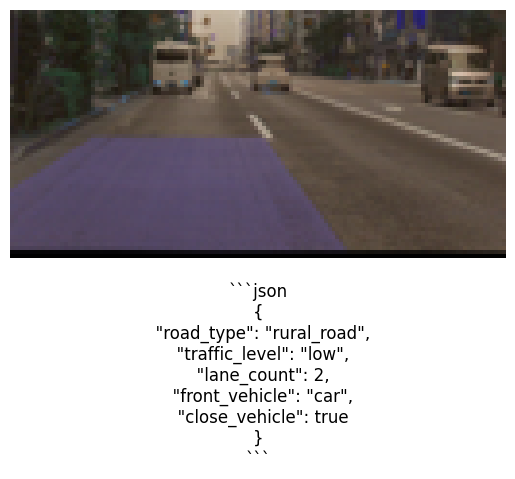

In [8]:
id_name = "0aa6298c8bf59b3ff5bfc60bbe4aff4e_420"

img_path = f"../../data/input/images/{id_name}/image_t.png"
inference_display(img_path, question, generation_config)
